In [ ]:
import cv2
import numpy as np
from ultralytics import YOLO
from shapely.geometry import Point, Polygon

# --- CONFIGURATION ---
VIDEO_PATH = '137322071489.mp4'
MODEL_PATH = 'best.pt'
PROCESS_LAST_SECONDS = 25
TOOL_CLASS_ID = 5  # Update this to match your YOLO ID for 'screwdriver' or 'tool'
DWELL_FRAMES = 30  # How many frames the tool must stay in zone to count (30 = ~1 sec)
REQUIRED_ORDER = ['BL', 'TR', 'BR', 'TL']  # Example Cross Order (Top-Left, Bottom-Right...)

# --- GLOBAL STATE ---
fixed_sequence = []
current_zone_focus = None
focus_counter = 0

def draw_text(img, text, pos, color=(0, 255, 0)):
    cv2.putText(img, text, pos, cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

# --- STEP 1: INTERACTIVE ZONE DRAWING ---
def select_zones(frame):
    print("\n--- INSTRUCTIONS ---")
    print("1. Click points to draw a polygon around a screw.")
    print("2. Press 'n' to save that zone and move to the next.")
    
    
    zone_names = ['BL', 'TR', 'BR', 'TL'] 
    defined_zones = {}
    
    # Create a copy so we don't draw permanently on the frame used for detection later
    display_frame = frame.copy()

    for name in zone_names:
        pts = []
        
        def click_event(event, x, y, flags, params):
            if event == cv2.EVENT_LBUTTONDOWN:
                pts.append((x, y))
                # Visual feedback for clicks
                cv2.circle(display_frame, (x, y), 4, (0, 0, 255), -1)
                cv2.imshow('Select Zones', display_frame)

        cv2.imshow('Select Zones', display_frame)
        cv2.setMouseCallback('Select Zones', click_event)
        
        print(f"Draw zone for {name}. Press 'n' when done.")
        
        while True:
            key = cv2.waitKey(1) & 0xFF
            if key == ord('n'):
                if len(pts) > 2:
                    defined_zones[name] = Polygon(pts)
                    # Draw the finished polygon permanently on our display copy
                    cv2.polylines(display_frame, [np.array(pts)], True, (0, 255, 0), 2)
                    cv2.putText(display_frame, name, pts[0], cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
                    break
                else:
                    print("Error: A zone needs at least 3 points!")
    
    cv2.destroyWindow('Select Zones')
    return defined_zones

# --- MAIN PIPELINE ---
# ... [Imports and Setup stay the same] ...

def main():
    global current_zone_focus, focus_counter
    
    # 1. Load Model
    print("Loading YOLO model...")
    model = YOLO(MODEL_PATH)
    
    # 2. Setup Video
    cap = cv2.VideoCapture(VIDEO_PATH)
    if not cap.isOpened():
        print("Error reading video file.")
        return

    # 3. SEEK TO START POSITION
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    duration = total_frames / fps
    
    start_sec = max(0, duration - PROCESS_LAST_SECONDS)
    start_frame = int(start_sec * fps)
    
    print(f"Video Duration: {duration:.2f}s. Seeking to {start_sec:.2f}s (Frame {start_frame})...")
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    # 4. DRAW ZONES
    ret, first_frame = cap.read()
    if not ret: return
    
    zones = select_zones(first_frame)
    print("Zones defined. Starting detection...")

    # 5. PROCESSING LOOP
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret: break
        
        # Run YOLO Inference
        results = model(frame, verbose=False)[0]
        
        # Draw Zones
        for name, poly in zones.items():
            pts = np.array(poly.exterior.coords, np.int32)
            color = (0, 255, 0) if name in fixed_sequence else (0, 0, 255) 
            cv2.polylines(frame, [pts], True, color, 2)
            cv2.putText(frame, name, (pts[0][0], pts[0][1]-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        # --- REPLACED: NEW TRACKING LOGIC ---
        # 1. Collect all valid tool detections
        tool_detections = []
        for box in results.boxes.data:
            x1, y1, x2, y2, conf, cls = box.tolist()
            if int(cls) == TOOL_CLASS_ID and conf > 0.4:
                tool_detections.append((conf, x1, y1, x2, y2))
        
        tool_point = None
        
        # 2. If we found tools, pick ONLY the one with highest confidence
        if tool_detections:
            # Sort by confidence (highest first)
            tool_detections.sort(key=lambda x: x[0], reverse=True)
            best_tool = tool_detections[0] # The "winner"
            
            _, x1, y1, x2, y2 = best_tool
            
            # 3. Calculate ONLY the Top Tip (y1)
            # y1 is the top edge (closest to 0). 
            tip_x = int((x1 + x2) / 2)
            tip_y = int(y1) 
            
            tool_point = Point(tip_x, tip_y)
            
            # Draw ONE pink cross at the top tip
            cv2.drawMarker(frame, (tip_x, tip_y), (255, 0, 255), cv2.MARKER_CROSS, 20, 3)
        # ------------------------------------

        # Logic: Is tool inside a zone?
        active_zone = None
        if tool_point:
            for name, poly in zones.items():
                if poly.contains(tool_point):
                    active_zone = name
                    break
        
        # Dwell Time Logic
        if active_zone and active_zone not in fixed_sequence:
            if active_zone == current_zone_focus:
                focus_counter += 1
            else:
                current_zone_focus = active_zone
                focus_counter = 1
            
            cv2.putText(frame, f"Fixing {active_zone}...", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)
            
            if focus_counter > DWELL_FRAMES: 
                fixed_sequence.append(active_zone)
                print(f"Confirmed: {active_zone} fixed.")
                focus_counter = 0
                current_zone_focus = None
        else:
            focus_counter = 0

        # Display Status
        status_text = f"Sequence: {fixed_sequence}"
        is_correct = (fixed_sequence == REQUIRED_ORDER[:len(fixed_sequence)])
        
        status_color = (0, 255, 0) if is_correct else (0, 0, 255)
        draw_text(frame, status_text, (20, frame.shape[0] - 40), (255, 255, 255))
        draw_text(frame, "STATUS: " + ("OK" if is_correct else "WRONG ORDER"), (20, frame.shape[0] - 80), status_color)

        cv2.imshow("Smart Screw Tracker", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()
    
    print("\n--- FINAL REPORT ---")
    print(f"Target: {REQUIRED_ORDER}")
    print(f"Actual: {fixed_sequence}")
    if fixed_sequence == REQUIRED_ORDER:
        print("RESULT: SUCCESS")
    else:
        print("RESULT: FAILURE")

if __name__ == "__main__":
    main()

Loading YOLO model...
Video Duration: 51.83s. Seeking to 26.83s (Frame 805)...

--- INSTRUCTIONS ---
1. Click points to draw a polygon around a screw.
2. Press 'n' to save that zone and move to the next.
Draw zone for BL. Press 'n' when done.


KeyboardInterrupt: 

: 

Loading YOLO model...


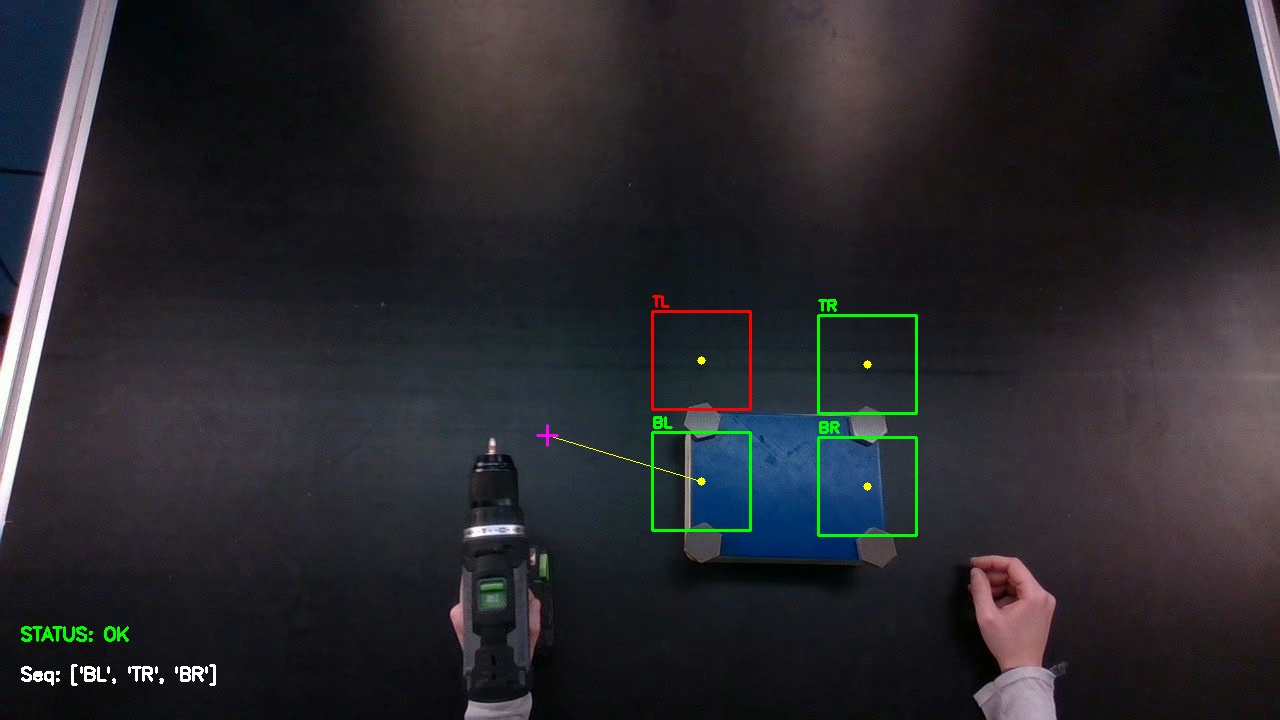

Tool Start Position Locked at: [     495.15      228.36]
LOCKED ON TOOL PICKUP!
Stopped.

Final: ['BL', 'TR', 'BR']


In [1]:
import cv2
import numpy as np
from ultralytics import YOLO
from shapely.geometry import Point, Polygon
from IPython.display import display, Image

# --- CONFIGURATION ---
VIDEO_PATH = '137322071489.mp4'  
MODEL_PATH = 'best.pt'
PROCESS_LAST_SECONDS = 35

# CLASS IDs
TOOL_CLASS_ID = 5   
SCREW_CLASS_ID = 4  

# SETTINGS
PLAYBACK_SPEED_X = 3       
DWELL_FRAMES = 5
REQUIRED_ORDER = ['BL', 'TR', 'BR', 'TL'] 

TRACKING_SETTINGS = {
    'MAX_STABLE_SPEED': 25.0,    
    'STRICT_HIT_RADIUS': 70,     
    'ANCHOR_SEARCH_RADIUS': 300, 
    'ROTATION_OFFSET': 0,
    'MIN_BOX_WIDTH_PX': 120,      
    
    # TRIGGER SETTINGS
    'TOOL_INIT_FRAMES': 5,      # <-- NEW: Wait 5 frames to confirm start pos
    'PICKUP_THRESHOLD_PX': 150  
}

# --- GLOBAL STATE ---
fixed_sequence = []
current_zone_focus = None
focus_counter = 0

box_state = {
    'locked': False,
    'centers': {},         
    'zones': {},
    'padding': 40,
    'centroid': None
}

# Tool State
tool_state = {
    'start_pos': None,
    'init_buffer': [], # <-- NEW: Buffer for averaging start pos
    'picked_up': False
}

prev_tool_pos = None

def draw_text(img, text, pos, color=(0, 255, 0), scale=0.6):
    cv2.putText(img, text, pos, cv2.FONT_HERSHEY_SIMPLEX, scale, color, 2)

def order_points_clockwise(pts):
    xSorted = pts[np.argsort(pts[:, 0]), :]
    leftMost = xSorted[:2, :]
    rightMost = xSorted[2:, :]
    leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
    (tl, bl) = leftMost
    rightMost = rightMost[np.argsort(rightMost[:, 1]), :]
    (tr, br) = rightMost
    return np.array([tl, tr, br, bl], dtype="float32")

def verify_box_size_and_shape(pts):
    (tl, tr, br, bl) = pts
    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    
    if ((widthA + widthB)/2) < TRACKING_SETTINGS['MIN_BOX_WIDTH_PX']: 
        return False, "TOO SMALL"
    if abs(widthA - widthB) > max(widthA, widthB) * 0.6: 
        return False, "DISTORTED"
    return True, "OK"

def complete_rectangle(three_points):
    max_dist = 0
    diag_pair = (0, 1)
    for i in range(3):
        for j in range(i+1, 3):
            d = np.linalg.norm(three_points[i] - three_points[j])
            if d > max_dist:
                max_dist = d
                diag_pair = (i, j)
    corner_idx = [x for x in [0, 1, 2] if x not in diag_pair][0]
    p_corner = three_points[corner_idx]
    p_A = three_points[diag_pair[0]]
    p_B = three_points[diag_pair[1]]
    midpoint = (p_A + p_B) / 2
    p_missing = 2 * midpoint - p_corner
    return np.vstack([three_points, p_missing])

def create_lock_from_screws(screw_boxes):
    centers = np.array([[s['cx'], s['cy']] for s in screw_boxes])
    
    # Phantom Logic (if hand blocks one screw)
    if len(centers) == 3:
        centers = complete_rectangle(centers)
        
    ordered = order_points_clockwise(centers)
    valid, reason = verify_box_size_and_shape(ordered)
    if not valid: return None, reason
    
    centroid = np.mean(ordered, axis=0)
    base_labels = ['TL', 'TR', 'BR', 'BL']
    labels = np.roll(base_labels, TRACKING_SETTINGS['ROTATION_OFFSET'])
    
    center_map = {}
    box_width = np.linalg.norm(ordered[0] - ordered[1])
    padding = int(box_width * 0.30) 
    
    zones = {}
    for i, label in enumerate(labels):
        center_map[label] = ordered[i]
        cx, cy = ordered[i]
        zones[label] = Polygon([
            (cx-padding, cy-padding), (cx+padding, cy-padding),
            (cx+padding, cy+padding), (cx-padding, cy+padding)
        ])
        
    return {
        'centers': center_map, 
        'padding': padding,
        'centroid': centroid,
        'zones': zones
    }, "OK"

def update_tracking(detections, state):
    if not detections: return state
    det_points = np.array([[d['cx'], d['cy']] for d in detections])
    shifts = []
    
    for label, known_pos in state['centers'].items():
        dists = np.linalg.norm(det_points - known_pos, axis=1)
        min_idx = np.argmin(dists)
        if dists[min_idx] < TRACKING_SETTINGS['ANCHOR_SEARCH_RADIUS']:
            shifts.append(det_points[min_idx] - known_pos)
            
    if shifts:
        avg_shift = np.mean(shifts, axis=0)
        for label in state['centers']:
            state['centers'][label] += avg_shift
        state['centroid'] += avg_shift
        pad = state['padding']
        for label, pos in state['centers'].items():
            cx, cy = pos
            state['zones'][label] = Polygon([
                (cx-pad, cy-pad), (cx+pad, cy-pad),
                (cx+pad, cy+pad), (cx-pad, cy+pad)
            ])
    return state

def main():
    global box_state, current_zone_focus, focus_counter, prev_tool_pos, tool_state
    
    print("Loading YOLO model...")
    try:
        model = YOLO(MODEL_PATH)
    except: return

    cap = cv2.VideoCapture(VIDEO_PATH)
    if not cap.isOpened(): return

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    if fps > 0:
        start_sec = max(0, (total_frames / fps) - PROCESS_LAST_SECONDS)
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(start_sec * fps))
    
    display_handle = display(None, display_id=True)
    frame_idx = 0

    try:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret: break
            frame_idx += 1
            if frame_idx % PLAYBACK_SPEED_X != 0: continue

            results = model(frame, verbose=False)[0]
            
            # 1. PARSE DETECTIONS
            screw_dets = []
            tool_data = None
            
            for box in results.boxes.data:
                x1, y1, x2, y2, conf, cls = box.tolist()
                cls = int(cls)
                if cls == SCREW_CLASS_ID and conf > 0.10: 
                    cx, cy = (x1 + x2) / 2, (y1 + y2) / 2
                    screw_dets.append({'cx': cx, 'cy': cy, 'conf': conf})
                    
                    # PHASE 1: ALWAYS DRAW SCREWS (Blue Boxes)
                    if not box_state['locked']:
                        cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (255, 200, 0), 2)
                        
                elif cls == TOOL_CLASS_ID and conf > 0.3: 
                    if tool_data is None or conf > tool_data[0]:
                        tool_data = (conf, x1, y1, x2, y2)

            # Tool Position Calc
            current_tip = None
            if tool_data:
                tx1, ty1, tx2, ty2 = tool_data[1:]
                current_tip = np.array([(tx1+tx2)/2, (ty1+ty2)/2])

            # 2. STATE MACHINE
            if not box_state['locked']:
                if current_tip is not None:
                    # --- NEW INITIALIZATION LOGIC ---
                    if tool_state['start_pos'] is None:
                        tool_state['init_buffer'].append(current_tip)
                        frames_left = TRACKING_SETTINGS['TOOL_INIT_FRAMES'] - len(tool_state['init_buffer'])
                        
                        if frames_left <= 0:
                            # Buffer full, calculate average start pos
                            avg_pos = np.mean(tool_state['init_buffer'], axis=0)
                            tool_state['start_pos'] = avg_pos
                            print(f"Tool Start Position Locked at: {avg_pos}")
                        else:
                            draw_text(frame, f"CALIBRATING TOOL... ({len(tool_state['init_buffer'])}/{TRACKING_SETTINGS['TOOL_INIT_FRAMES']})", (50, 50), (200, 200, 200))
                    
                    # Only proceed if start_pos is set
                    if tool_state['start_pos'] is not None:
                        # Check Displacement
                        dist = np.linalg.norm(current_tip - tool_state['start_pos'])
                        
                        # Draw tether to start
                        sx, sy = tool_state['start_pos']
                        cv2.circle(frame, (int(sx), int(sy)), 5, (0,0,255), -1) # Show start point
                        cv2.line(frame, (int(sx), int(sy)), (int(current_tip[0]), int(current_tip[1])), (0, 100, 255), 1)

                        if dist > TRACKING_SETTINGS['PICKUP_THRESHOLD_PX']:
                            # --- TRIGGER! ---
                            draw_text(frame, "PICKUP DETECTED! LOCKING...", (50, 80), (0, 255, 255))
                            
                            if len(screw_dets) >= 3:
                                screw_dets.sort(key=lambda x: x['conf'], reverse=True)
                                candidates = screw_dets[:4]
                                init, reason = create_lock_from_screws(candidates)
                                
                                if init:
                                    box_state.update(init)
                                    box_state['locked'] = True
                                    print("LOCKED ON TOOL PICKUP!")
                                else:
                                    draw_text(frame, f"BAD SCREW CONFIG: {reason}", (50, 110), (0, 0, 255))
                            else:
                                 draw_text(frame, "NEED 3+ SCREWS TO LOCK", (50, 110), (0, 0, 255))
                        else:
                            draw_text(frame, f"WAITING FOR PICKUP... (Move {int(dist)}/{TRACKING_SETTINGS['PICKUP_THRESHOLD_PX']}px)", (50, 50), (200, 200, 200))
                else:
                    # If tool is lost during init, reset buffer
                    if tool_state['start_pos'] is None:
                         tool_state['init_buffer'] = []
                    draw_text(frame, "TOOL NOT VISIBLE", (50, 50), (0, 0, 255))

            else:
                # 3. LOCKED TRACKING
                box_state = update_tracking(screw_dets, box_state)
                # Clamp tip for stability
                if current_tip is not None:
                    bx, by = box_state['centroid']
                    tx1, ty1, tx2, ty2 = tool_data[1:]
                    current_tip[0] = max(tx1, min(bx, tx2))
                    current_tip[1] = max(ty1, min(by, ty2))

            # 4. GAME LOGIC
            active_zone = None
            is_stable = False
            
            if current_tip is not None and box_state['locked']:
                if prev_tool_pos is not None:
                    adjusted_speed = np.linalg.norm(current_tip - prev_tool_pos) / PLAYBACK_SPEED_X
                    is_stable = adjusted_speed < TRACKING_SETTINGS['MAX_STABLE_SPEED']
                prev_tool_pos = current_tip

                nearest_label = None
                min_dist = float('inf')
                for label, center in box_state['centers'].items():
                    d = np.linalg.norm(current_tip - center)
                    if d < min_dist:
                        min_dist = d
                        nearest_label = label
                
                target_pos = box_state['centers'][nearest_label]
                line_color = (0, 255, 255) 
                thickness = 1
                
                if min_dist < TRACKING_SETTINGS['STRICT_HIT_RADIUS']:
                    line_color = (0, 255, 0) 
                    thickness = 3
                    if is_stable:
                        active_zone = nearest_label
                
                cv2.line(frame, (int(current_tip[0]), int(current_tip[1])), (int(target_pos[0]), int(target_pos[1])), line_color, thickness)
                cv2.drawMarker(frame, (int(current_tip[0]), int(current_tip[1])), (255, 0, 255), cv2.MARKER_CROSS, 20, 2)

            # 5. DRAW BOX
            if box_state['locked']:
                for name, poly in box_state['zones'].items():
                    if not poly: continue
                    pts = np.array(poly.exterior.coords, np.int32)
                    color = (0, 255, 0) if name in fixed_sequence else (0, 0, 255)
                    cv2.polylines(frame, [pts], True, color, 2)
                    c = box_state['centers'][name]
                    cv2.circle(frame, (int(c[0]), int(c[1])), 4, (0, 255, 255), -1)
                    cv2.putText(frame, name, (pts[0][0], pts[0][1]-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

            # 6. SEQUENCE CHECK
            if active_zone and is_stable and active_zone not in fixed_sequence:
                if active_zone == current_zone_focus:
                    focus_counter += 1
                else:
                    current_zone_focus = active_zone
                    focus_counter = 1
                
                bar_len = int((focus_counter / DWELL_FRAMES) * 100)
                cv2.rectangle(frame, (50, 80), (50+bar_len, 100), (0, 255, 255), -1)
                cv2.putText(frame, f"Fixing {active_zone}...", (50, 70), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)
                
                if focus_counter > DWELL_FRAMES: 
                    fixed_sequence.append(active_zone)
                    focus_counter = 0
            else:
                focus_counter = 0

            # 7. RENDER
            status = f"Seq: {fixed_sequence}"
            correct = (fixed_sequence == REQUIRED_ORDER[:len(fixed_sequence)])
            color = (0, 255, 0) if correct else (0, 0, 255)
            draw_text(frame, status, (20, frame.shape[0]-40), (255,255,255))
            draw_text(frame, "STATUS: OK" if correct else "STATUS: ERROR", (20, frame.shape[0]-80), color)

            _, jpeg = cv2.imencode('.jpg', frame)
            display_handle.update(Image(data=jpeg.tobytes()))

    except KeyboardInterrupt:
        print("Stopped.")
    
    cap.release()
    print(f"\nFinal: {fixed_sequence}")

if __name__ == "__main__":
    main()

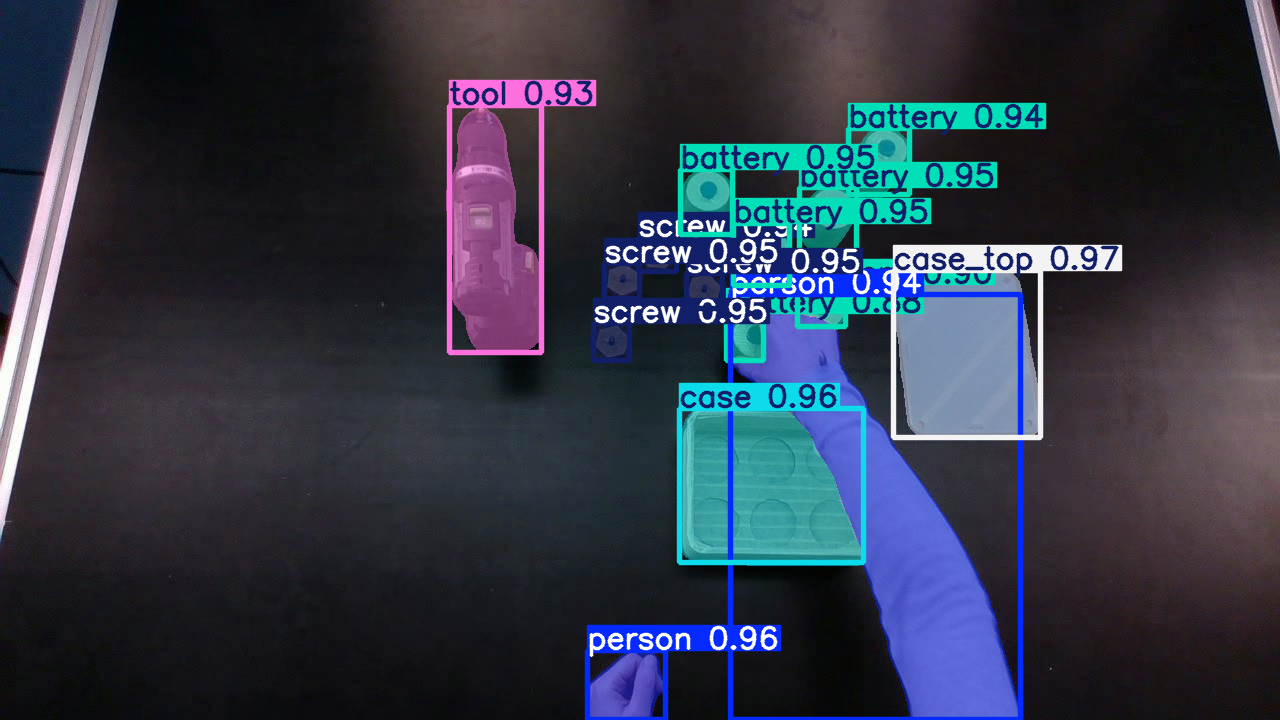


0: 736x1280 2 persons, 1 case, 1 case_top, 6 batterys, 4 screws, 1 tool, 230.5ms
Speed: 3.0ms preprocess, 230.5ms inference, 29.9ms postprocess per image at shape (1, 3, 736, 1280)
Stream stopped by user.
Video processing complete.


In [8]:
from ultralytics import YOLO
import cv2
from IPython.display import display, clear_output
from PIL import Image
import numpy as np

# --- CONFIG ---
MODEL_PATH = 'best.pt'         # <--- PUT YOUR MODEL PATH HERE
SOURCE_PATH = '137322071489.mp4' # <--- PUT YOUR VIDEO PATH HERE

def main():
    # 1. Load the model
    print(f"Loading model from {MODEL_PATH}...")
    try:
        model = YOLO(MODEL_PATH)
    except:
        print("Model not found. Downloading standard YOLOv8n for testing...")
        model = YOLO('yolov8n.pt')

    # 2. PRINT CLASS MAPPING
    print("\n--- CLASS MAPPING ---")
    print(model.names) 
    print("---------------------\n")

    # 3. Run inference
    cap = cv2.VideoCapture(SOURCE_PATH)
    
    if not cap.isOpened():
        print(f"Error: Could not open video source {SOURCE_PATH}")
        return

    try:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret: 
                break

            # Run prediction
            results = model(frame)

            # Get the annotated frame (numpy array)
            annotated_frame = results[0].plot()

            # --- COLOR CORRECTION ---
            # OpenCV uses BGR, but Notebooks/PIL use RGB. We must convert it.
            annotated_frame = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)

            # --- DISPLAY IN NOTEBOOK ---
            # Convert numpy array to PIL Image
            img = Image.fromarray(annotated_frame)
            
            # Clear the previous output (wait=True prevents flickering)
            clear_output(wait=True)
            
            # Display the new image
            display(img)

    except KeyboardInterrupt:
        print("Stream stopped by user.")
        
    finally:
        cap.release()
        print("Video processing complete.")

if __name__ == "__main__":
    main()

Loading YOLO model...


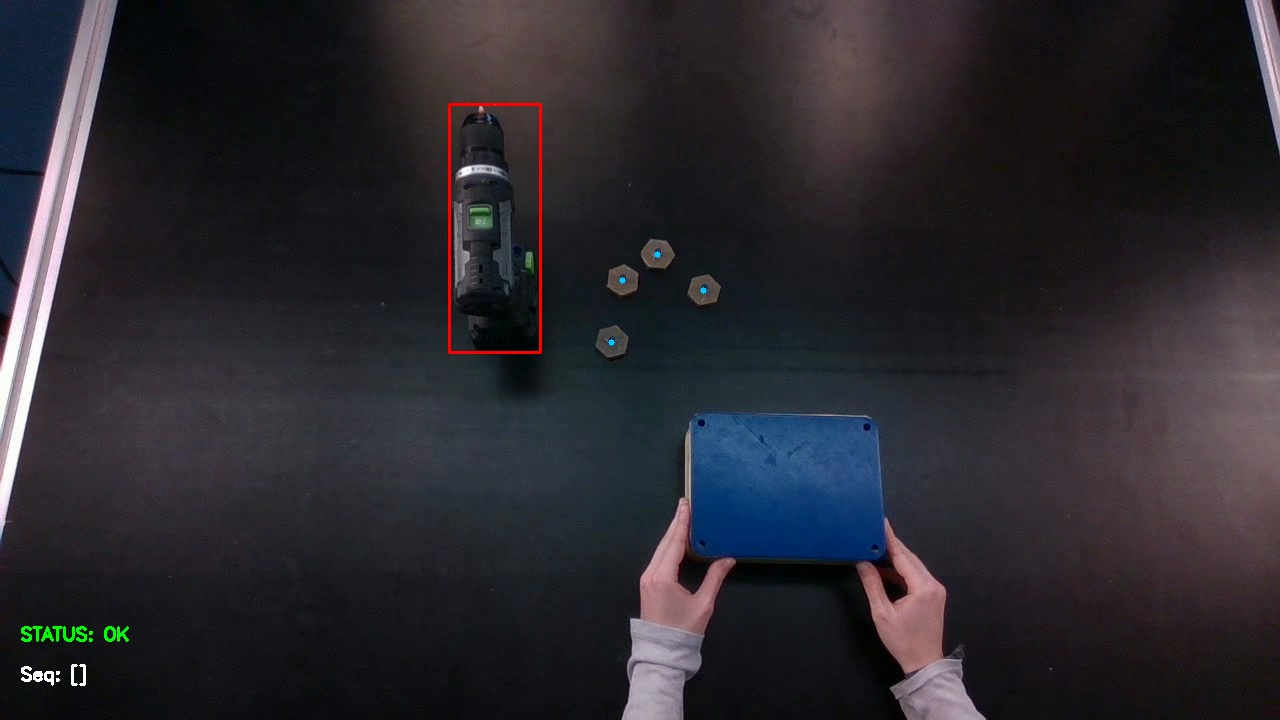

Tool Calibrated.
Stopped.

Final Sequence: []


In [21]:
import cv2
import numpy as np
from ultralytics import YOLO
from IPython.display import display, Image

# --- CONFIGURATION ---
VIDEO_PATH = '137322071489.mp4'  
MODEL_PATH = 'best.pt'
PROCESS_LAST_SECONDS = 35

# CLASS IDs
TOOL_CLASS_ID = 5   
SCREW_CLASS_ID = 4  

# SETTINGS
PLAYBACK_SPEED_X = 2        
DWELL_FRAMES = 5
REQUIRED_ORDER = ['BL', 'TR', 'BR', 'TL'] 

TRACKING_SETTINGS = {
    'STRICT_HIT_RADIUS': 75,      # Increased slightly for easier first hit
    'MIN_BOX_WIDTH_PX': 80,      
    
    # TRIGGER SETTINGS - TUNED FOR INSTANT START
    'TOOL_INIT_FRAMES': 3,        # Was 5 -> Calibrate faster
    'PICKUP_THRESHOLD_PX': 20     # Was 100 -> Wake up INSTANTLY on movement
}

# --- STATE ---
fixed_sequence = []
current_zone_focus = None
focus_counter = 0

box_state = {
    'locked': False,
    'ref_shape': None,    
    'curr_points': None,  
    'labels': ['TL', 'TR', 'BR', 'BL']
}

tool_state = {
    'start_pos': None,
    'init_buffer': []
}

prev_tool_pos = None

def draw_text(img, text, pos, color=(0, 255, 0), scale=0.6, thickness=2):
    cv2.putText(img, text, pos, cv2.FONT_HERSHEY_SIMPLEX, scale, color, thickness)

def order_points_clockwise(pts):
    pts = pts[pts[:, 1].argsort()]
    top = pts[:2]
    bottom = pts[2:]
    top = top[top[:, 0].argsort()]
    bottom = bottom[bottom[:, 0].argsort()]
    return np.array([top[0], top[1], bottom[1], bottom[0]], dtype="float32")

def lock_box(screw_boxes):
    centers = np.array([[s['cx'], s['cy']] for s in screw_boxes])
    if len(centers) != 4: return None, f"NEED 4 POINTS (GOT {len(centers)})"

    ordered = order_points_clockwise(centers)
    return {
        'ref_shape': ordered,     
        'curr_points': ordered,   
        'labels': ['TL', 'TR', 'BR', 'BL']
    }, "OK"

def update_rigid_tracking(detections, state):
    if not detections or state['ref_shape'] is None: 
        return state

    obs_points = np.array([[d['cx'], d['cy']] for d in detections], dtype="float32")
    last_known = state['curr_points']
    ref_shape = state['ref_shape']
    
    pairs = []
    for i, known_pt in enumerate(last_known):
        dists = np.linalg.norm(obs_points - known_pt, axis=1)
        for j, d in enumerate(dists):
            if d < 80: 
                pairs.append((i, j, d))
    
    pairs.sort(key=lambda x: x[2])
    
    src_pts = []
    dst_pts = []
    used_known = set()
    used_obs = set()
    
    for i, j, d in pairs:
        if i not in used_known and j not in used_obs:
            src_pts.append(ref_shape[i])
            dst_pts.append(obs_points[j])
            used_known.add(i)
            used_obs.add(j)
            
    src_pts = np.array(src_pts)
    dst_pts = np.array(dst_pts)
    
    M = None
    if len(dst_pts) >= 2:
        M, _ = cv2.estimateAffinePartial2D(src_pts, dst_pts)
        
    if M is not None:
        ref_reshaped = ref_shape.reshape(-1, 1, 2)
        transformed = cv2.transform(ref_reshaped, M)
        state['curr_points'] = transformed.reshape(4, 2)
        
    return state

def merge_tool_boxes(boxes):
    if not boxes: return None
    x1s = [b[0] for b in boxes]; y1s = [b[1] for b in boxes]
    x2s = [b[2] for b in boxes]; y2s = [b[3] for b in boxes]
    return (min(x1s), min(y1s), max(x2s), max(y2s))

def main():
    global box_state, current_zone_focus, focus_counter, prev_tool_pos, tool_state
    
    print("Loading YOLO model...")
    model = YOLO(MODEL_PATH)
    
    cap = cv2.VideoCapture(VIDEO_PATH)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    if fps > 0:
        start_sec = max(0, (total_frames / fps) - PROCESS_LAST_SECONDS)
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(start_sec * fps))
        
    display_handle = display(None, display_id=True)
    frame_idx = 0

    try:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret: break
            frame_idx += 1
            if frame_idx % PLAYBACK_SPEED_X != 0: continue

            # --- 1. DETECTION ---
            results = model(frame, verbose=False)[0]
            screw_dets = []
            tool_boxes_raw = []
            
            for box in results.boxes.data:
                x1, y1, x2, y2, conf, cls = box.tolist()
                if int(cls) == SCREW_CLASS_ID and conf > 0.15:
                    cx, cy = (x1 + x2) / 2, (y1 + y2) / 2
                    screw_dets.append({'cx': cx, 'cy': cy, 'conf': conf})
                    if not box_state['locked']:
                        cv2.circle(frame, (int(cx), int(cy)), 3, (255, 200, 0), -1)

                elif int(cls) == TOOL_CLASS_ID and conf > 0.35:
                    tool_boxes_raw.append((x1, y1, x2, y2))
            
            # --- 2. MERGE LOGIC ---
            final_tool_box = merge_tool_boxes(tool_boxes_raw)
            
            current_tip = None
            if final_tool_box:
                x1, y1, x2, y2 = final_tool_box
                cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 255), 2)
                # STRICT TOP-CENTER TIP
                current_tip = np.array([(x1+x2)/2, y1])

            # --- 3. LOGIC ---
            if not box_state['locked']:
                if current_tip is not None:
                    # Calibration
                    if tool_state['start_pos'] is None:
                        tool_state['init_buffer'].append(current_tip)
                        if len(tool_state['init_buffer']) > TRACKING_SETTINGS['TOOL_INIT_FRAMES']:
                            tool_state['start_pos'] = np.mean(tool_state['init_buffer'], axis=0)
                            print("Tool Calibrated.")
                    else:
                        sx, sy = tool_state['start_pos']
                        cv2.line(frame, (int(sx), int(sy)), (int(current_tip[0]), int(current_tip[1])), (0, 100, 255), 1)
                        dist = np.linalg.norm(current_tip - tool_state['start_pos'])
                        
                        # --- FAST START LOGIC ---
                        if dist > TRACKING_SETTINGS['PICKUP_THRESHOLD_PX']:
                            if len(screw_dets) >= 4: 
                                screw_dets.sort(key=lambda x: x['conf'], reverse=True)
                                data, reason = lock_box(screw_dets[:4])
                                if data:
                                    box_state.update(data)
                                    box_state['locked'] = True
                                    print("LOCKED!")
            else:
                # TRACKING
                box_state = update_rigid_tracking(screw_dets, box_state)
                corners = box_state['curr_points']
                labels = box_state['labels']
                
                # Draw Box
                pts = corners.astype(np.int32).reshape((-1, 1, 2))
                cv2.polylines(frame, [pts], True, (0, 255, 0), 2)
                
                active_zone = None
                
                if current_tip is not None:
                    # Draw Tip
                    cv2.drawMarker(frame, (int(current_tip[0]), int(current_tip[1])), (255, 0, 255), cv2.MARKER_CROSS, 20, 3)
                    
                    dists = [np.linalg.norm(current_tip - c) for c in corners]
                    min_dist = min(dists)
                    nearest_idx = dists.index(min_dist)
                    
                    t_pt = corners[nearest_idx]
                    cv2.line(frame, (int(current_tip[0]), int(current_tip[1])), (int(t_pt[0]), int(t_pt[1])), (255, 0, 0), 1)

                    is_stable = False
                    if prev_tool_pos is not None:
                         speed = np.linalg.norm(current_tip - prev_tool_pos)
                         if speed < 40.0: is_stable = True
                    prev_tool_pos = current_tip
                    
                    if min_dist < TRACKING_SETTINGS['STRICT_HIT_RADIUS']:
                        target = labels[nearest_idx]
                        cv2.line(frame, (int(current_tip[0]), int(current_tip[1])), (int(t_pt[0]), int(t_pt[1])), (0, 255, 0), 3)
                        
                        if is_stable:
                            active_zone = target

                # Labels
                for i, pt in enumerate(corners):
                    c = (0, 255, 255)
                    if active_zone == labels[i]: c = (0, 255, 0)
                    cx, cy = int(pt[0]), int(pt[1])
                    cv2.circle(frame, (cx, cy), 5, c, -1)
                    cv2.putText(frame, labels[i], (cx-10, cy-15), cv2.FONT_HERSHEY_SIMPLEX, 0.6, c, 2)

                # Sequence
                if active_zone and is_stable:
                    if active_zone == current_zone_focus:
                        focus_counter += 1
                    else:
                        current_zone_focus = active_zone
                        focus_counter = 1
                    
                    if active_zone not in fixed_sequence:
                        bar = int((focus_counter/DWELL_FRAMES)*50)
                        cv2.rectangle(frame, (50, 60), (50+bar, 70), (0, 255, 0), -1)
                        if focus_counter > DWELL_FRAMES:
                            fixed_sequence.append(active_zone)
                            focus_counter = 0
                else:
                    focus_counter = 0

            # UI
            status = f"Seq: {fixed_sequence}"
            correct = (fixed_sequence == REQUIRED_ORDER[:len(fixed_sequence)])
            color = (0, 255, 0) if correct else (0, 0, 255)
            draw_text(frame, status, (20, frame.shape[0]-40), (255,255,255))
            draw_text(frame, "STATUS: OK" if correct else "STATUS: ERROR", (20, frame.shape[0]-80), color)

            _, jpeg = cv2.imencode('.jpg', frame)
            display_handle.update(Image(data=jpeg.tobytes()))

    except KeyboardInterrupt:
        print("Stopped.")

    cap.release()
    print(f"\nFinal Sequence: {fixed_sequence}")

if __name__ == "__main__":
    main()
#####
#####
####
#WORKS GOOD####
#ADD LLM

Loading YOLO model...


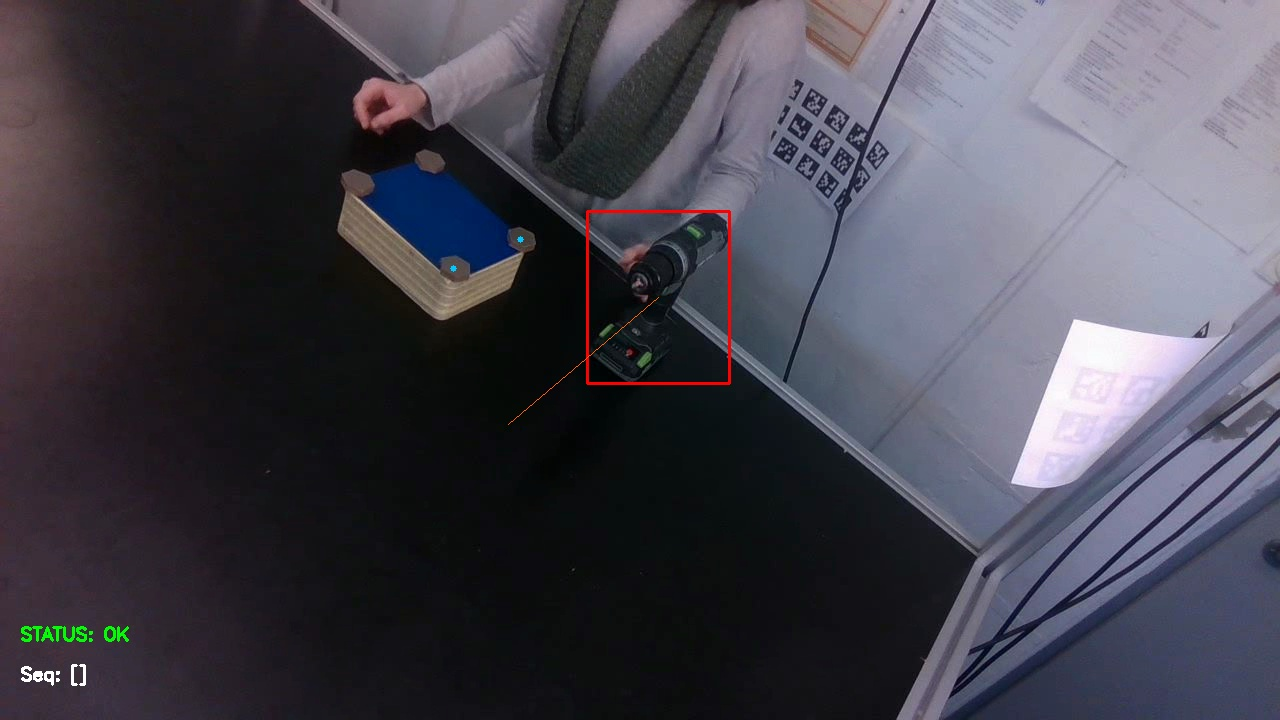

Tool Calibrated.
Stopped.

Final Sequence: []


In [34]:
import cv2
import numpy as np
from ultralytics import YOLO
from IPython.display import display, Image
from collections import deque

# --- CONFIGURATION ---
VIDEO_PATH = '135122071615.mp4'  
MODEL_PATH = 'best.pt'
PROCESS_LAST_SECONDS = 35

# CLASS IDs
PERSON_CLASS_ID = 0  # Standard YOLO 'person'
SCREW_CLASS_ID = 4
TOOL_CLASS_ID = 5   

# SETTINGS
PLAYBACK_SPEED_X = 2        
DWELL_FRAMES = 5
REQUIRED_ORDER = ['BL', 'TR', 'BR', 'TL'] 

TRACKING_SETTINGS = {
    'STRICT_HIT_RADIUS': 80,     
    'TOOL_INIT_FRAMES': 3,
    'PICKUP_THRESHOLD_PX': 20,
    'TOOL_SMOOTH_FACTOR': 0.5
}

# --- STATE ---
fixed_sequence = []
current_zone_focus = None
focus_counter = 0

box_state = {
    'locked': False,
    'ref_shape': None,    
    'curr_points': None,  
    'labels': ['TL', 'TR', 'BR', 'BL']
}

tool_state = {
    'start_pos': None,
    'init_buffer': [],
    'box_smooth': None,
    'last_person_pos': None # Remembers where the operator is
}

prev_tool_pos = None

def draw_text(img, text, pos, color=(0, 255, 0), scale=0.6, thickness=2):
    cv2.putText(img, text, pos, cv2.FONT_HERSHEY_SIMPLEX, scale, color, thickness)

def order_points_angular(pts):
    centroid = np.mean(pts, axis=0)
    angles = np.arctan2(pts[:, 1] - centroid[1], pts[:, 0] - centroid[0])
    sorted_pts = pts[np.argsort(angles)]
    sums = sorted_pts[:, 0] + sorted_pts[:, 1]
    tl_idx = np.argmin(sums)
    return np.roll(sorted_pts, -tl_idx, axis=0)

def lock_box(screw_boxes):
    centers = np.array([[s['cx'], s['cy']] for s in screw_boxes])
    if len(centers) != 4: return None, "NEED 4 POINTS"
    ordered = order_points_angular(centers)
    return {
        'ref_shape': ordered,     
        'curr_points': ordered,   
        'labels': ['TL', 'TR', 'BR', 'BL']
    }, "OK"

def update_fail_safe_tracking(detections, state):
    if not detections or state['ref_shape'] is None: return state
    obs_points = np.array([[d['cx'], d['cy']] for d in detections], dtype="float32")
    
    # 1. HARD RESET
    if len(obs_points) == 4:
        state['curr_points'] = order_points_angular(obs_points)
        return state

    # 2. PARTIAL TRACKING
    last_known = state['curr_points']
    ref_shape = state['ref_shape']
    pairs = []
    for i, known_pt in enumerate(last_known):
        dists = np.linalg.norm(obs_points - known_pt, axis=1)
        for j, d in enumerate(dists):
            if d < 80: pairs.append((i, j, d))
    
    pairs.sort(key=lambda x: x[2])
    src_pts, dst_pts, used_known, used_obs = [], [], set(), set()
    
    for i, j, d in pairs:
        if i not in used_known and j not in used_obs:
            src_pts.append(ref_shape[i])
            dst_pts.append(obs_points[j])
            used_known.add(i); used_obs.add(j)
    
    src_pts = np.array(src_pts); dst_pts = np.array(dst_pts)
    
    if len(dst_pts) >= 2:
        M, _ = cv2.estimateAffinePartial2D(src_pts, dst_pts)
        if M is not None:
            ref_reshaped = ref_shape.reshape(-1, 1, 2)
            transformed = cv2.transform(ref_reshaped, M)
            state['curr_points'] = transformed.reshape(4, 2)
    return state

def get_person_relative_tip(tool_box, person_center):
    """
    CRITICAL LOGIC:
    Calculates the 'Away Vector' from Person -> Tool.
    The Tip is the point on the Tool Box that is furthest in that direction.
    """
    x1, y1, x2, y2 = tool_box
    tool_cx = (x1 + x2) / 2
    tool_cy = (y1 + y2) / 2
    
    # 4 Candidate Points on the Tool Box
    candidates = [
        np.array([tool_cx, y1]), # Top
        np.array([tool_cx, y2]), # Bottom
        np.array([x1, tool_cy]), # Left
        np.array([x2, tool_cy])  # Right
    ]
    
    if person_center is None:
        # Fallback: Assume person is at bottom of screen -> Tip is Top
        return candidates[0] 
        
    person_pt = np.array(person_center)
    
    # Find the candidate that is FURTHEST from the person
    dists = [np.linalg.norm(c - person_pt) for c in candidates]
    best_idx = np.argmax(dists) # Max distance = "Away" side
    
    return candidates[best_idx]

def merge_boxes(boxes):
    if not boxes: return None
    x1s = [b[0] for b in boxes]; y1s = [b[1] for b in boxes]
    x2s = [b[2] for b in boxes]; y2s = [b[3] for b in boxes]
    return [min(x1s), min(y1s), max(x2s), max(y2s)]

def main():
    global box_state, current_zone_focus, focus_counter, prev_tool_pos, tool_state
    
    print("Loading YOLO model...")
    model = YOLO(MODEL_PATH)
    cap = cv2.VideoCapture(VIDEO_PATH)
    
    # Seek
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    if fps > 0:
        start_sec = max(0, (total_frames / fps) - PROCESS_LAST_SECONDS)
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(start_sec * fps))
        
    display_handle = display(None, display_id=True)
    frame_idx = 0

    try:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret: break
            frame_idx += 1
            if frame_idx % PLAYBACK_SPEED_X != 0: continue

            # --- DETECT EVERYTHING ---
            # Classes: 0=Person, 4=Screw, 5=Tool
            results = model(frame, verbose=False)[0]
            screw_dets = []
            tool_boxes_raw = []
            person_boxes_raw = []
            
            for box in results.boxes.data:
                x1, y1, x2, y2, conf, cls = box.tolist()
                cls = int(cls)
                
                if cls == SCREW_CLASS_ID and conf > 0.15:
                    cx, cy = (x1 + x2) / 2, (y1 + y2) / 2
                    screw_dets.append({'cx': cx, 'cy': cy, 'conf': conf})
                    if not box_state['locked']:
                        cv2.circle(frame, (int(cx), int(cy)), 3, (255, 200, 0), -1)

                elif cls == TOOL_CLASS_ID and conf > 0.30:
                    tool_boxes_raw.append([x1, y1, x2, y2])
                    
                elif cls == PERSON_CLASS_ID and conf > 0.30:
                    person_boxes_raw.append([x1, y1, x2, y2])
            
            # --- MERGE ---
            final_tool_box = merge_boxes(tool_boxes_raw)
            final_person_box = merge_boxes(person_boxes_raw)
            
            # --- PERSON MEMORY ---
            # If we see the person, remember where they are.
            # If they disappear (occlusion), assume they haven't moved much.
            if final_person_box:
                px1, py1, px2, py2 = final_person_box
                pcx, pcy = (px1+px2)/2, (py1+py2)/2
                tool_state['last_person_pos'] = (pcx, pcy)
                
                # Debug: Person Center
                # cv2.circle(frame, (int(pcx), int(pcy)), 10, (255, 0, 0), -1)

            # --- LOGIC ---
            if not box_state['locked']:
                if final_tool_box:
                    x1, y1, x2, y2 = final_tool_box
                    cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 255), 2)
                    
                    # Calibration (Simple Center for now)
                    current_tip = np.array([(x1+x2)/2, (y1+y2)/2])
                    
                    if tool_state['start_pos'] is None:
                        tool_state['init_buffer'].append(current_tip)
                        if len(tool_state['init_buffer']) > TRACKING_SETTINGS['TOOL_INIT_FRAMES']:
                            tool_state['start_pos'] = np.mean(tool_state['init_buffer'], axis=0)
                            print("Tool Calibrated.")
                    else:
                        sx, sy = tool_state['start_pos']
                        cv2.line(frame, (int(sx), int(sy)), (int(current_tip[0]), int(current_tip[1])), (0, 100, 255), 1)
                        dist = np.linalg.norm(current_tip - tool_state['start_pos'])
                        
                        if dist > TRACKING_SETTINGS['PICKUP_THRESHOLD_PX']:
                            if len(screw_dets) >= 4: 
                                screw_dets.sort(key=lambda x: x['conf'], reverse=True)
                                data, reason = lock_box(screw_dets[:4])
                                if data:
                                    box_state.update(data)
                                    box_state['locked'] = True
                                    print("LOCKED!")
            else:
                # TRACKING
                box_state = update_fail_safe_tracking(screw_dets, box_state)
                corners = box_state['curr_points']
                labels = box_state['labels']
                
                # Draw Box
                pts = corners.astype(np.int32).reshape((-1, 1, 2))
                cv2.polylines(frame, [pts], True, (0, 255, 0), 2)
                
                active_zone = None
                
                if final_tool_box:
                    # --- PERSON-RELATIVE TIP ---
                    current_tip = get_person_relative_tip(final_tool_box, tool_state['last_person_pos'])
                    
                    # Visual: Pink X
                    cv2.drawMarker(frame, (int(current_tip[0]), int(current_tip[1])), (255, 0, 255), cv2.MARKER_CROSS, 20, 3)
                    
                    dists = [np.linalg.norm(current_tip - c) for c in corners]
                    min_dist = min(dists)
                    nearest_idx = dists.index(min_dist)
                    
                    t_pt = corners[nearest_idx]
                    cv2.line(frame, (int(current_tip[0]), int(current_tip[1])), (int(t_pt[0]), int(t_pt[1])), (255, 0, 0), 1)

                    is_stable = False
                    if prev_tool_pos is not None:
                         speed = np.linalg.norm(current_tip - prev_tool_pos)
                         if speed < 40.0: is_stable = True
                    prev_tool_pos = current_tip
                    
                    if min_dist < TRACKING_SETTINGS['STRICT_HIT_RADIUS']:
                        target = labels[nearest_idx]
                        cv2.line(frame, (int(current_tip[0]), int(current_tip[1])), (int(t_pt[0]), int(t_pt[1])), (0, 255, 0), 3)
                        if is_stable: active_zone = target

                for i, pt in enumerate(corners):
                    c = (0, 255, 255)
                    if active_zone == labels[i]: c = (0, 255, 0)
                    cx, cy = int(pt[0]), int(pt[1])
                    cv2.circle(frame, (cx, cy), 5, c, -1)
                    cv2.putText(frame, labels[i], (cx-10, cy-15), cv2.FONT_HERSHEY_SIMPLEX, 0.6, c, 2)

                if active_zone and is_stable:
                    if active_zone == current_zone_focus:
                        focus_counter += 1
                    else:
                        current_zone_focus = active_zone
                        focus_counter = 1
                    
                    if active_zone not in fixed_sequence:
                        bar = int((focus_counter/DWELL_FRAMES)*50)
                        cv2.rectangle(frame, (50, 60), (50+bar, 70), (0, 255, 0), -1)
                        if focus_counter > DWELL_FRAMES:
                            fixed_sequence.append(active_zone)
                            focus_counter = 0
                else:
                    focus_counter = 0

            status = f"Seq: {fixed_sequence}"
            correct = (fixed_sequence == REQUIRED_ORDER[:len(fixed_sequence)])
            color = (0, 255, 0) if correct else (0, 0, 255)
            draw_text(frame, status, (20, frame.shape[0]-40), (255,255,255))
            draw_text(frame, "STATUS: OK" if correct else "STATUS: ERROR", (20, frame.shape[0]-80), color)

            _, jpeg = cv2.imencode('.jpg', frame)
            display_handle.update(Image(data=jpeg.tobytes()))

    except KeyboardInterrupt:
        print("Stopped.")

    cap.release()
    print(f"\nFinal Sequence: {fixed_sequence}")

if __name__ == "__main__":
    main()